In [1]:
import torch
from torch import nn,Tensor
from d2l import torch as d2l

In [27]:
def batch_norm(X:Tensor,gamma,beta,moving_mean,moving_var,eps,momentum):
  """批量规范化

  Args:
      X (Tensor): 传入的X
      gamma (_type_): 拉伸量
      beta (_type_): 偏移量
      moving_mean (_type_): 移动平均值
      moving_var (_type_): 移动方差
      eps (_type_): 噪声
      momentum (_type_): 动量

  Returns:
      _type_: 规范化后的X，移动平均值，移动方差
  """
  if not torch.is_grad_enabled():
    # 在预测模式下直接使用传入的均值和方差
    X_hat = (X-moving_mean) / torch.sqrt(moving_var+eps)
  else:
    assert len(X.shape) in (2,4)
    if len(X.shape) == 2:
      # 使用全连接层
      mean:Tensor = X.mean(dim=0)
      var:Tensor = ((X - mean) ** 2).mean(dim=0)
    else:
      # 先沿着宽高计算均值，再沿着批次计算均值
      mean:Tensor = X.mean(dim=(0,2,3),keepdim=True)
      var:Tensor = ((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
    # 训练模式用当前方差做标准化
    X_hat = (X-mean) / torch.sqrt(var+eps)
    # 更新移动平均的均值和方差
    moving_mean:Tensor = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var:Tensor = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta
  return Y,moving_mean.data,moving_var.data

In [29]:
class BatchNorm(nn.Module):
  def __init__(self,num_features,num_dims) -> None:
    super().__init__()
    if num_dims == 2:
      shape = (1,num_features)
    else:
      shape = (1,num_features,1,1)
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.ones(shape))
    
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)
  def forward(self,X):
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    Y,self.moving_mean,self.moving_var = batch_norm(
      X,self.gamma,self.beta,self.moving_mean,self.moving_var,
      eps=1e-5,momentum=0.9
    )
    return Y

In [30]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.245, train acc 0.909, test acc 0.862
15041.9 examples/sec on cuda:0


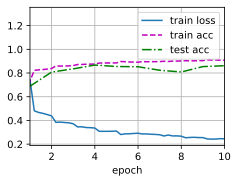

In [33]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [35]:
net[1].gamma.reshape(-1,),net[1].beta.reshape(-1)

(tensor([3.4224, 2.9831, 2.4389, 3.5101, 2.7259, 5.1450], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([3.2946, 2.5194, 4.1639, 0.6355, 2.3551, 2.3272], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [39]:
net = nn.Sequential(
  nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2,stride=2),
  nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
  nn.Linear(256,120),nn.BatchNorm1d(120),nn.Sigmoid(),
  nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
  nn.Linear(84,10)
)

loss 0.261, train acc 0.904, test acc 0.834
27997.8 examples/sec on cuda:0


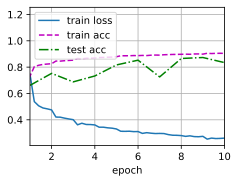

In [40]:
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())